In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
epsilon = 0.1

def exact_solution():
    xs = np.linspace(-.42, .42, 1001)
    return xs ** 3 - epsilon * xs, xs

etas, xs = exact_solution()

def scalar_newton(func, jac, x0, atol=1e-14, max_iter=50, **kwargs):
    xi = x0
    for n_iter in range(max_iter):
        delta = -func(xi, **kwargs) / jac(xi, **kwargs)
        xi += delta 
        if abs(delta) < atol:
            return xi
        
def multi_newton(func, jac, X0, args=(), atol=1e-14, max_iter=50):
    xi = X0.copy()
    for n_iter in range(max_iter):
        # print(np.abs(func(xi, *args)).sum())
        delta = -np.linalg.solve(jac(xi, *args), func(xi, *args))
        xi += delta
        if np.abs(delta).sum() / len(delta) < atol:
            return xi

def F(x, eta=0):
    return eta + epsilon * x - x**3

def J(x, eta=0):
    return epsilon - 3 * x**2

def natural_continuation(etas, x0):
    xs = np.zeros_like(etas)
    xprev = x0
    for k, eta in enumerate(etas):
        xs[k] = scalar_newton(F, J, xprev, eta=eta)
        xprev = xs[k]
    return xs

def F_eta(y):
    return 1

def Ftilda(y, y0, tau0, ds):
    x, eta = y
    df = eta + epsilon * x - x ** 3
    dp = np.dot(y-y0, tau0) - ds
    return np.array([df, dp])

def Jtilda(y, y0, tau0, ds):
    x, eta = y
    jac = np.zeros((2, 2))
    jac[0, :] = [epsilon - 3 * x ** 2, F_eta(y)]
    jac[1, :] = tau0
    return jac

def get_tangent(y, prev_tau):
    x, eta = y
    tau = np.array([-F_eta(y) / J(x, eta), 1])
    if np.dot(tau, prev_tau) < 0:
        tau = - tau
    return tau / np.linalg.norm(tau)

def pseudo_arclength(eta_span, y0, ds=0.01):
    eta0, etaf = eta_span
    direction = 1 if etaf > eta0 else -1
    tau0 = np.zeros_like(y0)
    eta = eta0

    y = y0.copy()
    ys = []
    etas = []
    while eta < etaf:
        # print(f'eta = {eta}')
        tau0 = get_tangent(y, tau0)
        y = multi_newton(Ftilda, Jtilda, y, args=(y, tau0, ds))
        if y is None:
            print(etas[-1])
        ys.append(y[0])
        etas.append(y[1])
        eta = etas[-1]
    return etas, ys

In [3]:
y0 = np.array([-0.4, -0.05])
eta0, etaf = y0[1], -y0[1]
direction = 1 if etaf > eta0 else -1
tau0 = np.zeros_like(y0)
tau0[-1] = -direction
tau0 = get_tangent(y0, tau0)
ds = 0.1

print(Jtilda(y0 + ds * tau0, y0, tau0, ds))

multi_newton(Ftilda, Jtilda, y0 + ds * tau0, args=(y0, tau0, ds))

[[-0.63056267  1.        ]
 [-0.93478358 -0.35521776]]


array([-0.49797458, -0.07368962])

In [4]:
etas, ys = pseudo_arclength((eta0, etaf), y0)

In [5]:
%matplotlib qt
plt.plot(etas, ys, '.')

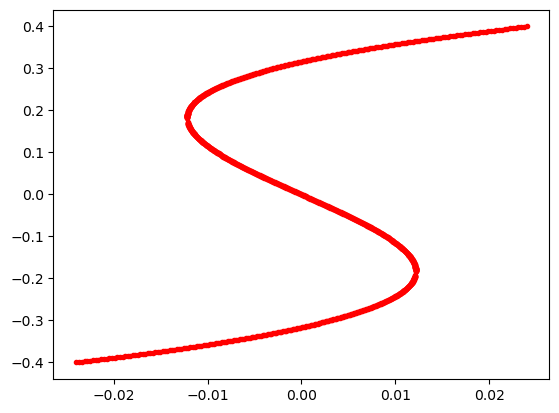

In [6]:
etas, xs = exact_solution()
newt = np.zeros_like(etas)
for k, eta in enumerate(etas):
    newt[k] = scalar_newton(F, J, xs[k] + 0.01, eta=eta)
plt.plot(etas, xs)
plt.plot(etas, newt, 'r.')

In [18]:
%matplotlib qt

In [9]:
plt.plot(*exact_solution(), label='exact')
etas_newt = np.linspace(-0.02, 0.02, 11)
plt.plot(*pseudo_arclength((eta0, etaf), y0, ds=0.02), '.', label='pseudo-arclength',
         color='tab:orange')
plt.xlim(-0.025, 0.025)
# plt.plot(etas_newt, natural_continuation(etas_newt, -0.4), '>', label='continuation forward')
# plt.plot(etas_newt[::-1], natural_continuation(etas_newt[::-1], 0.4), '<', label='continuation backward')
plt.legend()
plt.show()